In [1]:
import networkx as nx
import numpy as np; np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate

from simulate import ODE_simulate, GILL_simulate
from plot_module import plot_ODE, plot_gillespie, plot_network
from sim_param_from_network import names_from_network, gillespie_reaction_dict_from_network, dataframes_from_network, ODE_from_network
from network_generate import linear_network

In [2]:
MAX_T = 5000
TIME_POINTS = np.linspace(0, MAX_T, 500)

## Define network topology and numeric parameters

In [3]:
# G = nx.DiGraph()

# G.add_node('N1', birth_type=2, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)
# G.add_node('N2', birth_type=1, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)
# G.add_node('N3', birth_type=1, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)
# G.add_node('N4', birth_type=1, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)
# G.add_node('N5', birth_type=1, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)

# G.add_edge('N1', 'N2', rate=0.15)
# G.add_edge('N2', 'N3', rate=0.15)
# G.add_edge('N3', 'N4', rate=0.15)
# G.add_edge('N4', 'N5', rate=0.15)
# G.add_edge('N5', 'N1', rate=0.15)

# plot_network(G)
# VARS, COMP = names_from_network(G)

# # set a given starting state
# start_state = [190, 20, 190, 20, 190, 20, 190, 20, 190, 20]

In [4]:
# G = nx.DiGraph()

# G.add_node('Soma', birth_type=2, c_b = 0.1, birth_rate = 0.14, nss=200, delta = 0.5, death_rate = 0.07,)
# G.add_node('Axon', birth_type=0, c_b = 0.1, birth_rate = 0.00, nss=200, delta = 0.5, death_rate = 0.07,)

# G.add_edge('Soma', 'Axon', rate=0.14)
# G.add_edge('Axon', 'Soma', rate=0.07)

# plot_network(G)
# VARS, COMP = names_from_network(G)

# # set a given starting state
# start_state = [190, 20, 190, 20]

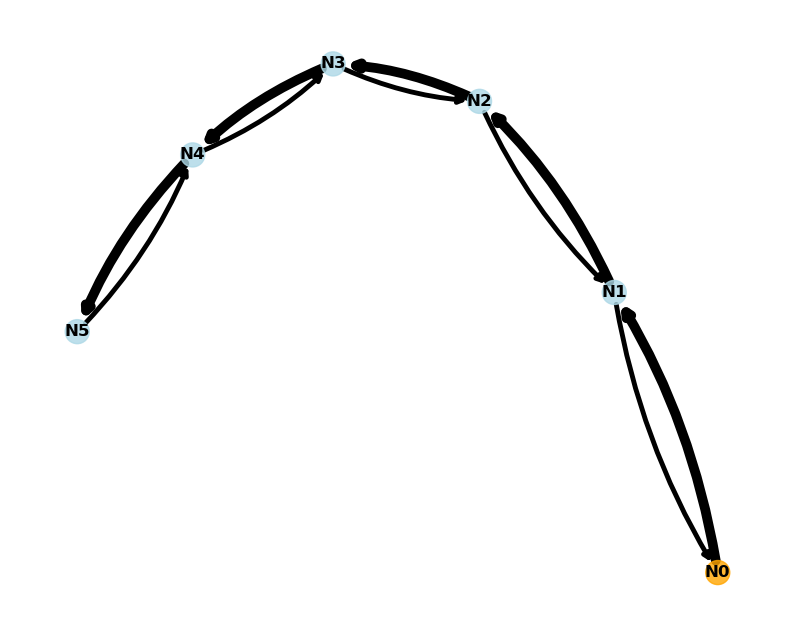

In [10]:
bio_param = {'c_b' : 0.1, 'mu_a' : 0.14, 'nss' : 100, 'delta' : 0.5, 'mu' : 0.07,'gamma_ant':0.14, 'gamma_ret':0.07}
G, VARS, COMP, start_state = linear_network(6, bio_param, start_pop = [90, 20])
plot_network(G)

## Get ODE representation of network, and run simulation

In [11]:
ODE_model = ODE_from_network(G)

> Code for ODE model:

global ODE_model
def ODE_model(t, z):
	# variables (node name + wt/mt)
	N0_wt, N0_mt, N1_wt, N1_mt, N2_wt, N2_mt, N3_wt, N3_mt, N4_wt, N4_mt, N5_wt, N5_mt = z
	return [
		# ΔN0_wt/Δt
		(N0_wt*((0.14 + 0.1*(100-N0_wt-(0.5*N0_mt)))-(0.07)-(0.14)))+(N1_wt*0.07),
		# ΔN0_mt/Δt
		(N0_mt*((0.14 + 0.1*(100-N0_wt-(0.5*N0_mt)))-(0.07)-(0.14)))+(N1_mt*0.07),
		# ΔN1_wt/Δt
		(N1_wt*(0-(0.07)-(0.21)))+(N0_wt*0.14)+(N2_wt*0.07),
		# ΔN1_mt/Δt
		(N1_mt*(0-(0.07)-(0.21)))+(N0_mt*0.14)+(N2_mt*0.07),
		# ΔN2_wt/Δt
		(N2_wt*(0-(0.07)-(0.21)))+(N1_wt*0.14)+(N3_wt*0.07),
		# ΔN2_mt/Δt
		(N2_mt*(0-(0.07)-(0.21)))+(N1_mt*0.14)+(N3_mt*0.07),
		# ΔN3_wt/Δt
		(N3_wt*(0-(0.07)-(0.21)))+(N2_wt*0.14)+(N4_wt*0.07),
		# ΔN3_mt/Δt
		(N3_mt*(0-(0.07)-(0.21)))+(N2_mt*0.14)+(N4_mt*0.07),
		# ΔN4_wt/Δt
		(N4_wt*(0-(0.07)-(0.21)))+(N3_wt*0.14)+(N5_wt*0.07),
		# ΔN4_mt/Δt
		(N4_mt*(0-(0.07)-(0.21)))+(N3_mt*0.14)+(N5_mt*0.07),
		# ΔN5_wt/Δt
		(N5_wt*(0-(0.07)-(0.07)))+(N4_wt*0.14),
		# ΔN5_mt/Δt
		(N

> Final counts of mt and wt in each compartment:
N0_wt	89.7393	
N0_mt	19.9421	
N1_wt	52.6058	
N1_mt	11.6902	
N2_wt	30.9446	
N2_mt	6.8766	
N3_wt	18.5668	
N3_mt	4.1259	
N4_wt	12.3778	
N4_mt	2.7506	
N5_wt	12.3778	
N5_mt	2.7506	

> Final effective population sizes in each compartment:
N0	99.7103	
N1	58.4509	
N2	34.3829	
N3	20.6297	
N4	13.7532	
N5	13.7532	


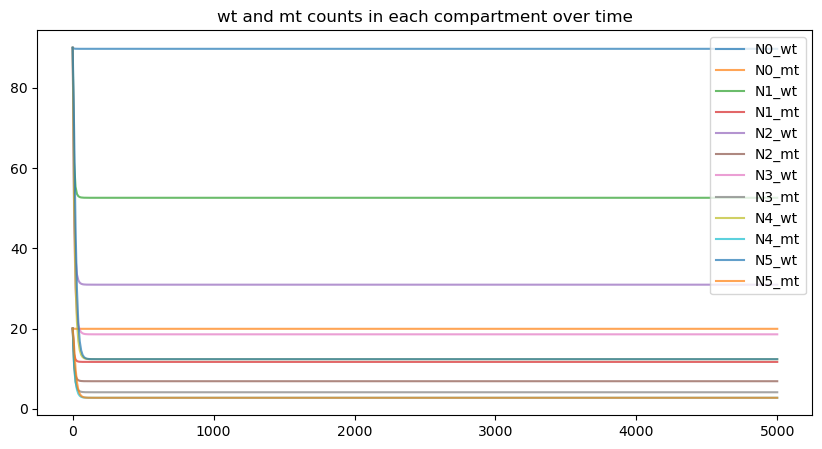

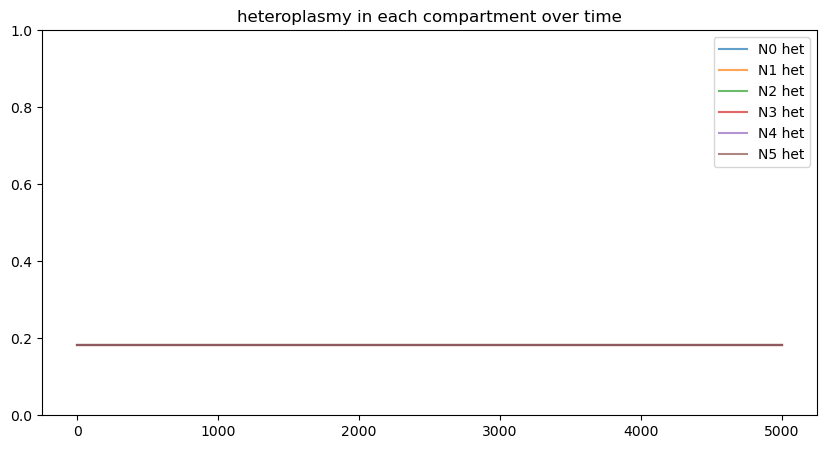

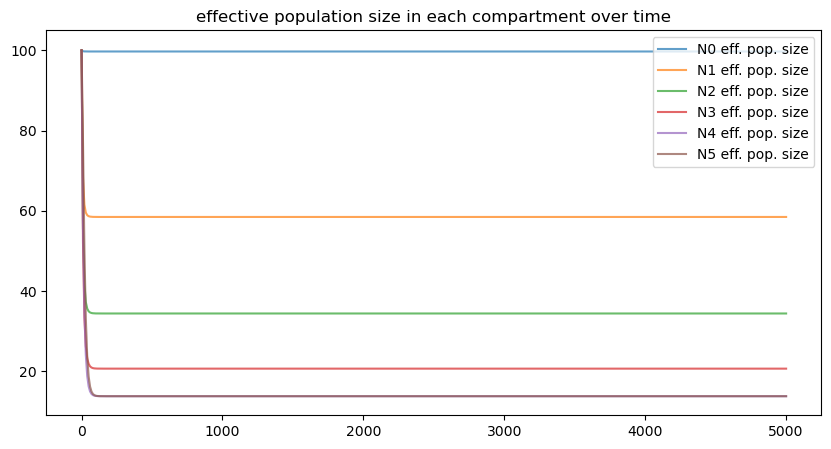

In [12]:
ode_results = ODE_simulate(ODE_model, TIME_POINTS, start_state)
plot_ODE(ode_results, TIME_POINTS, 0.5, VARS, COMP)

## Get gillespie simulation for network

In [13]:
gill_param = gillespie_reaction_dict_from_network(G)

> Reactions:
react.#	state i	type	rate	update to system
0	0	birth	-1	[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1	1	birth	-1	[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2	0	death	0.07	[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3	1	death	0.07	[0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4	2	death	0.07	[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
5	3	death	0.07	[0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0]
6	4	death	0.07	[0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0]
7	5	death	0.07	[0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0]
8	6	death	0.07	[0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0]
9	7	death	0.07	[0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0]
10	8	death	0.07	[0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0]
11	9	death	0.07	[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0]
12	10	death	0.07	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]
13	11	death	0.07	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
14	0	trnspt	0.14	[-1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
15	1	trnspt	0.14	[0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
16	2	trnspt	0.07	[1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
17	3	trnspt	0.07	[0, 1, 0, -1, 0, 0, 

In [14]:
gill_results = GILL_simulate(gill_param, TIME_POINTS, start_state, replicates=2000, onedynamic = True)

simulating...


/home/daniel/Projects/2023_Jones_Lab_mtDNA/SSD/SSD_Neuron/plot_module.py:93: RuntimeWarning: invalid value encountered in true_divide
  het = np.nanmean(mt_counts[:,i,:]/(mt_counts[:,i,:]+wt_counts[:,i,:]), axis = 0)


> Final mean counts of mt and wt in each compartment:
N0_wt	78.131	
N0_mt	43.2225	
N1_wt	45.63	
N1_mt	25.4525	
N2_wt	26.9605	
N2_mt	14.9115	
N3_wt	16.1265	
N3_mt	8.9065	
N4_wt	10.826	
N4_mt	6.0285	
N5_wt	10.7355	
N5_mt	6.015	

> Final mean heteroplasmy in each compartment:
N0	0.217	
N1	0.217	
N2	0.2171	
N3	0.2171	
N4	0.2169	
N5	0.2171	

> Final mean effective population sizes in each compartment:
N0	99.7422	
N1	58.3562	
N2	34.4162	
N3	20.5798	
N4	13.8402	
N5	13.743	

> Change in mean heteroplasmy: 
start: 0.1818
final: 0.2174
delta: 0.0356


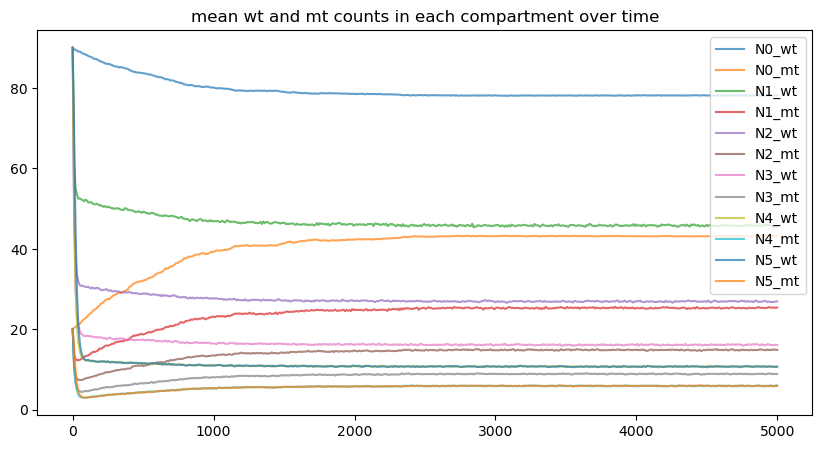

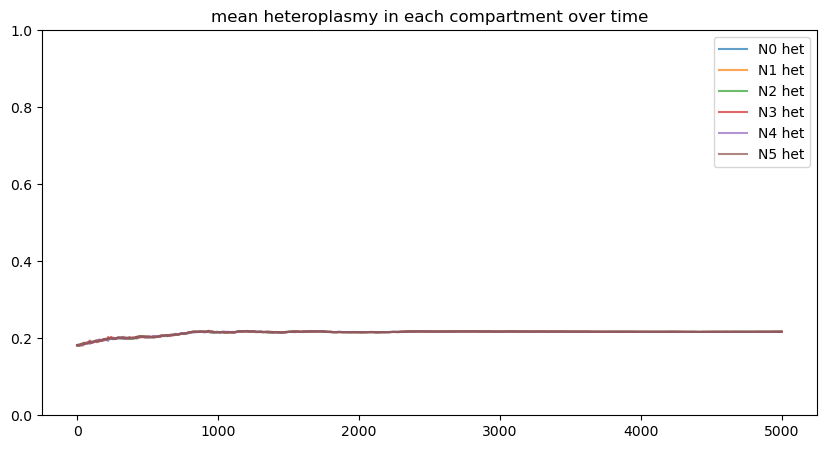

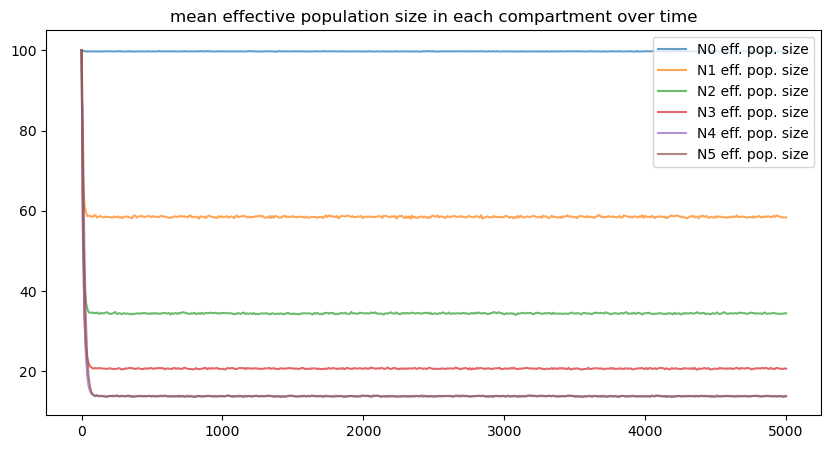

In [15]:
plot_gillespie(gill_results, TIME_POINTS, 0.5, VARS, COMP)